In [2]:
library(ggplot2)
library(reshape2)
library(tidyverse)
library(grid)
library(ggpubr)
theme_set(theme_pubr())
source('./scripts//plottingUtils.R')
options(repr.plot.width=4, repr.plot.height=3)
figdir <- './writing/nontext/figures/'

gdf <- loadData()
gdf[c(1:2,1020:1021,550:551,2000:2001),]
print(unique(gdf$Stat))

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.2  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



,genus,variable,value,Stat,CRISPR.Status,StatType,CRISPR.Fraction
1,Acetobacter,indel_rate.crispr_rate,1.000000e+02,indel_rate,crispr,rate,0.2916667
2,Acholeplasma,indel_rate.crispr_rate,5.118657e-02,indel_rate,crispr,rate,0.2000000
1063,Bartonella,indel_rate.non.crispr_sem,1.394070e-01,indel_rate,non.crispr,sem,0.0000000
1064,Bdellovibrio,indel_rate.non.crispr_sem,3.091388e-02,indel_rate,non.crispr,sem,0.1666667
569,Pseudonocardia,indel_rate.internal_rate,2.161106e+00,indel_rate,NA,rate,0.1428571
570,Pseudothermotoga,indel_rate.internal_rate,6.283064e-01,indel_rate,NA,rate,1.0000000
2236,Riemerella,centrality.crispr_sem,2.018795e-04,centrality,crispr,sem,0.7272727
2237,Rothia,centrality.crispr_sem,5.359697e-04,centrality,crispr,sem,0.6000000


[1] "indel_rate"         "taxa"               "assortativity"     
[4] "centrality"         "closeness_vitaltiy" "clustering"        
[7] "degree"             "mean_edge_weight"   "modularity"        


In [9]:
wilcoxtest <- function(stat,df){
    data <- dcast(gdf[(gdf$Stat==stat)&(!(is.na(gdf$CRISPR.Status))),],
                  genus ~ CRISPR.Status + StatType)
    print(dim(data))
    wiltest <- wilcox.test(data$crispr_mean,data$non.crispr_mean,paired=TRUE)
    return(wiltest)
}

[1] 197   5



	Wilcoxon signed rank test with continuity correction

data:  data$crispr_mean and data$non.crispr_mean
V = 5182, p-value = 0.07412
alternative hypothesis: true location shift is not equal to 0


[1] 197   5



	Wilcoxon signed rank test with continuity correction

data:  data$crispr_mean and data$non.crispr_mean
V = 7193, p-value = 0.001981
alternative hypothesis: true location shift is not equal to 0


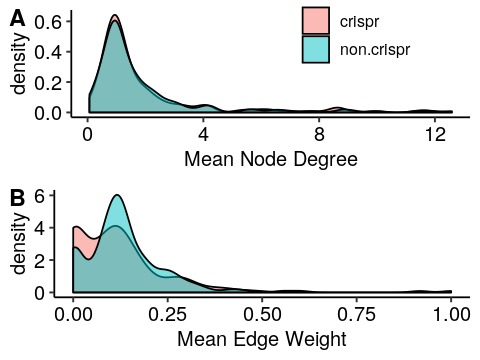

In [10]:
data <- dcast(gdf[(gdf$Stat=='degree')&(!(is.na(gdf$CRISPR.Status))),],genus + CRISPR.Status ~ StatType)
wilcoxtest('degree',gdf)
degree <- ggplot(data,aes(x=mean,fill=CRISPR.Status)) + 
    geom_density(alpha=0.5) +
    xlab('Mean Node Degree') + 
    theme(legend.position=c(0.75,0.9),panel.background=element_rect('white'))

data <- dcast(gdf[(gdf$Stat=='mean_edge_weight')&(!(is.na(gdf$CRISPR.Status))),],genus + CRISPR.Status ~ StatType)
wilcoxtest('mean_edge_weight',gdf)
edge_weight <- ggplot(data,aes(x=mean,fill=CRISPR.Status)) + 
    geom_density(alpha=0.5) +
    xlab('Mean Edge Weight') + 
    theme(legend.position='',panel.background=element_rect('white'))
fig <- ggarrange(degree, edge_weight,
                    labels = c("A", "B"),
                    ncol = 1, nrow = 2)
ggsave(file.path(figdir,'status_vs_degree_weight.png'),fig,height=10,width=14,units='cm')
fig

[1] 128   5


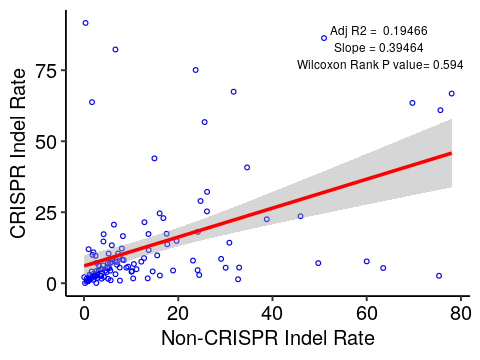

In [68]:
data <- dcast(gdf[(gdf$Stat=='indel_rate')&(!(is.na(gdf$CRISPR.Status))),],genus ~ CRISPR.Status + StatType)
data <- data[(data$non.crispr_rate!=100)&(data$crispr_rate!=100),]
data <- data[(data$non.crispr_rate!=-1)&(data$crispr_rate!=-1),]
print(dim(data))
fit <- lm(non.crispr_rate ~ crispr_rate, data=data)
wiltest <- wilcox.test(data$crispr_rate,data$non.crispr_rate,paired=TRUE)
statslabel <- paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                    "\nSlope =",signif(fit$coef[[2]], 5),
                    #"\nP value =",signif(summary(fit)$coef[2,4], 5),
                    "\nWilcoxon Rank P value=",signif(wiltest$p.value,4))
ggplot(data,aes(x=non.crispr_rate,y=crispr_rate)) + 
    geom_point(size=1,shape=1,color='blue') +
    geom_smooth(method='lm',col='red') +
    annotate('text',label=statslabel,color='black',size=2.5,x=63,y=83) + 
    xlab('Non-CRISPR Indel Rate') +
    ylab('CRISPR Indel Rate') +
    #ggtitle('Gene Indel Rates Across Genera') +
    theme(legend.position='top',panel.background=element_rect(fill='white'))
ggsave(file.path(figdir,'cindel_vs_ncindel.png'),height=10,width=14,units='cm')

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.3644904811,0.025497195,14.2953169,1.442563e-30
rate,-0.0003156696,0.001011461,-0.3120929,7.553688e-01


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),4.614335e-01,0.024772262,18.627021300,3.487895e-40
rate,6.099065e-06,0.001112718,0.005481233,9.956342e-01


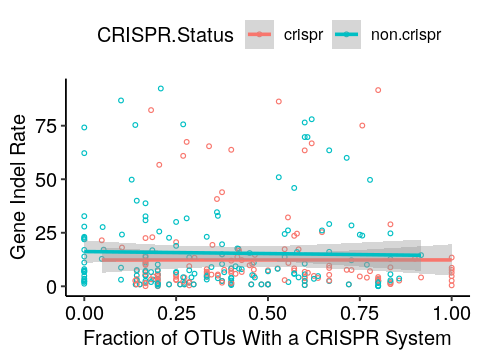

In [20]:
data <- dcast(gdf[(gdf$Stat=='indel_rate')&(!(is.na(gdf$CRISPR.Status))),],genus + CRISPR.Status + CRISPR.Fraction ~ StatType)
data <- data[(data$rate!=100)&(data$rate!=-1),]
ncfit <- lm(CRISPR.Fraction ~ rate,data=data[data$CRISPR.Status=='non.crispr',])
cfit <- lm(CRISPR.Fraction ~ rate,data=data[data$CRISPR.Status=='crispr',])
summary(ncfit)$coef
summary(cfit)$coef
ggplot(data,aes(x=CRISPR.Fraction,y=rate)) + 
    geom_point(aes(col=CRISPR.Status),size=1,shape=1) +
    geom_smooth(method='lm',aes(col=CRISPR.Status)) + xlim(0,1) +
    xlab('Fraction of OTUs With a CRISPR System') +
    ylab('Gene Indel Rate') +
    theme(legend.position='top',panel.background=element_rect(fill='white'))
ggsave(file.path(figdir,'fraction_vs_indel.png'),height=10,width=14,units='cm')

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.008945  0.070704  0.093770  0.101582  0.126948  0.218750 

[1] 197   4


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.60000 -0.18283 -0.07925 -0.11910 -0.04025  0.25000 

[1] 157   4


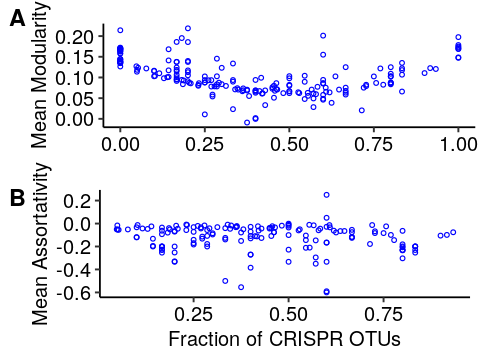

In [21]:
gdf[(gdf$variable=="modularity.mean"),]$StatType <- 'mean'
gdf[(gdf$variable=="modularity.sem"),]$StatType <- 'sem'
data <- dcast(gdf[(gdf$Stat=="modularity"),],genus + CRISPR.Fraction ~ StatType)
cf <- gdf[gdf$variable=='modularity.mean',]$CRISPR.Fraction
summary(gdf[gdf$variable=='modularity.mean',]$value)
print(dim(data))
modularity <- ggplot(data,aes(x=CRISPR.Fraction,y=mean)) + 
    geom_point(size=1,shape=1,col='blue') +
    ylab('\nMean Modularity') + xlab('') +
    #geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width=0.02) +
    theme(legend.position='',panel.background=element_rect('white'),
          plot.margin=unit(c(0.5,0.1,0,0.2),"cm"))

gdf[(gdf$variable=="assortativity.mean"),]$StatType <- 'mean'
gdf[(gdf$variable=="assortativity.sem"),]$StatType <- 'sem'
data <- dcast(gdf[(gdf$Stat=="assortativity"),],genus + CRISPR.Fraction ~ StatType)
summary(gdf[gdf$variable=='assortativity.mean',]$value)
print(dim(data))
assortativity <- ggplot(data,aes(x=CRISPR.Fraction,y=mean)) + 
    geom_point(size=1,shape=1,col='blue') +
    ylab('\nMean Assortativity') + xlab('Fraction of CRISPR OTUs') +
    #geom_errorbar(aes(ymin = mean - sem, ymax = mean + sem), width=0.02) +
    theme(legend.position='',panel.background=element_rect('white'))
fig <- ggarrange(modularity, assortativity,
                    labels = c("A", "B"),
                    ncol = 1, nrow = 2)
ggsave(file.path(figdir,'assort_and_mod.png'),fig,height=10,width=14,units='cm')
fig

In [71]:
#plotPairedMetric('degree',gdf)
#plotPairedMetric('mean_edge_weight',gdf[gdf$value!=0,])
#plotPairedMetric('clustering',gdf)
#plotPairedMetric('centrality',gdf)

#data <- dcast(gdf[(gdf$Stat=='degree')&(!(is.na(gdf$CRISPR.Status))),],genus + CRISPR.Status ~ StatType)
#ggplot(data,aes(x=mean,fill=CRISPR.Status)) + 
#    geom_density() +
#    xlab('Mean Node Degree') +
#    theme(legend.position='top')

#print(dim(gdf[gdf$variable=='degree.mw_pval',]))
#mwplot <- ggplot(gdf[gdf$variable=='degree.mw_pval',],aes(-log10(value))) + 
#    geom_density() +
#    #geom_vline(xintercept=-log10(0.005)) +
#    xlab('Degree Mann-Whitney -log10(p-value)') +
#    theme(legend.position='top')